In [15]:
import sys
import os
import torch
import torchvision

import torch.nn as nn
import torch.optim as optim


import torchvision.transforms as transforms
import torchvision.transforms.functional as fn
from PIL import Image
import matplotlib.pyplot as plt
import numpy as np
from collections import Counter
from Dataset import Dataset
from CNN_model import CNNModel


import warnings
warnings.filterwarnings('ignore')
from tqdm.notebook import tqdm

In [8]:
train = Dataset(subset = 'train')
val = Dataset(subset = 'val')
test = Dataset(subset = 'test')

Label :  happy


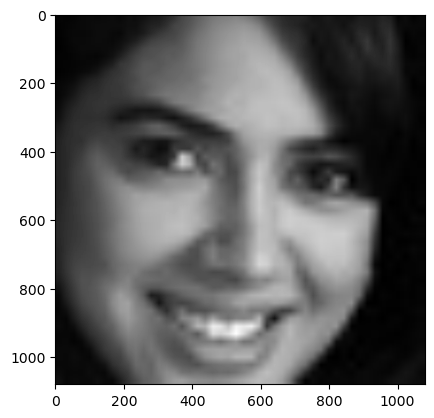

In [9]:
i = 0
val.plotImage(i)

In [10]:
# hyper parameters
seed = 100
torch.manual_seed(seed)

batch  = 128

In [11]:
train_loader = torch.utils.data.DataLoader(
        dataset=train,
        batch_size=batch,
        shuffle=True,
)

val_loader = torch.utils.data.DataLoader(
        dataset=val,
        batch_size=batch,
        shuffle=True,
)

test_loader = torch.utils.data.DataLoader(
        dataset=val,
        batch_size=batch,
        shuffle=True,
)

In [12]:

# for cuda devices
#device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# for mps devices
#device = torch.device("mps" if torch.backends.mps.is_available() else "cpu")


model = CNNModel().to(device)
optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.9, weight_decay = 0.0005)
loss_fn = nn.CrossEntropyLoss()
epochs = 30

In [13]:
# dont run this cell before training atleast once

checkpoint = torch.load("emoji_model2.pth", map_location=torch.device('mps'))
print("=> Loading checkpoint")
model.load_state_dict(checkpoint["state_dict"])
optimizer.load_state_dict(checkpoint["optimizer"])
# 61% accuracy

=> Loading checkpoint


In [ ]:
# Training loop
model.train()
for epoch in range(epochs):
  loop=tqdm(train_loader)
  mean_loss=[]
  correct_pred=0
  for data,label in loop:
    data, label, model =data.to(device), label.to(device), model.to(device)
    pred = model(data)
    loss = loss_fn(pred, label)
    mean_loss.append(loss.item())
    _,y_hat = torch.max(pred,dim=1)
    correct_pred +=  (y_hat == label).sum().item()
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    loop.set_postfix(loss=loss.item())
  if optimizer.param_groups[0]['lr'] > 0.000005 :
      optimizer.param_groups[0]['lr'] -= 0.000001

  print(f"Mean loss of epoch is {sum(mean_loss)/len(train_loader)}")
  print(f"Mean accuracy of epoch is {100 * correct_pred/50000}")

  model.eval()  
  val_crct = 0
  val_total = 0
  for val_data,val_label in val_loader:
    val_data, val_label, model =val_data.to(device), val_label.to(device), model.to(device)
    with torch.no_grad():
        pred = model(val_data)
    _,y_hat = torch.max(pred,dim=1)
    val_crct +=  (y_hat == val_label).sum().item()
    val_total += val_label.size(0)
  print(f"validation accuracy is {100 * val_crct/val_total}")
  model.train()    
    
  checkpoint = {
                "state_dict": model.state_dict(),
                "optimizer": optimizer.state_dict(),
           }
  print("=> Saving checkpoint")
  torch.save(checkpoint, "emoji_model.pth")

In [11]:
model = CNNModel()
loss_fn = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.9)
                
n_epochs = 10
for epoch in range(n_epochs):
    for i, (images, labels) in enumerate(train_loader):
        # Forward pass 
        outputs = model(images)
        loss = loss_fn(outputs, labels)

        # Backward pass and optimize
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    correct = 0
    total = 0
    with torch.no_grad():
        for images, labels in test_loader:
            outputs = model(images)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    print('Epoch %d: Accuracy: %d %%' % (epoch,(100 * correct / total)))


torch.Size([1, 48, 48])
torch.Size([1, 48, 48])
torch.Size([1, 48, 48])
torch.Size([1, 48, 48])
torch.Size([1, 48, 48])
torch.Size([1, 48, 48])
torch.Size([1, 48, 48])
torch.Size([1, 48, 48])


KeyboardInterrupt: 

In [ ]:
import cv2

cv2.ocl.setUseOpenCL(False)

# emotion_dict = {0: "Angry", 1: "Disgusted", 2: "Fearful", 3: "Happy", 4: "Neutral", 5: "Sad", 6: "Surprised"}

# VideoCapture(0 => webcam) otherwise provide the path of the saved video
cap = cv2.VideoCapture(0)

model = model.to('cpu')
# front face detector (pretrained model) 
Classifier = cv2.CascadeClassifier('haarcascade_frontalface_default.xml')

while True:
    # ret is a bool , True if the frame reading was successful
    # frame is the picture
    ret, frame = cap.read()

    # if ret is False
    if not ret:
        # closes video
        cap.release()
        cv2.destroyAllWindows()
        break

    
    # convert frame to gray scale to match the training set
    gray_frame = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)


    
    # detecting the frontal faces for the current frame
    bounding_boxes = Classifier.detectMultiScale(frame,scaleFactor=1.3, minNeighbors=5)
    # whenever a face is detected, calssifier determines its bounding box
    # each bounding box = [x,y,w,h] => 
    # x,y : the upper right corner coordinates of the box
    # w,h : the width and the height of the box


    # for each bounding box
    for (x, y, w, h) in bounding_boxes:
        # drawing the boundig box onto the video frame (the original one not the gray one)
        cv2.rectangle(frame, (x, y-50), (x+w, y+h+10), (255, 0, 0), 2)
        # rectangle takes the upper right corner : (x, y-50) and the lower left corner : (x+w, y+h+10) of the rectangle

        # cropping the image around the bounding box of the face to input only the face to the emotion detection model
        roi_gray_frame = gray_frame[y:y + h, x:x + w]

        
        # resize the cropped image to (48,48) like the training set
        cropped_img = cv2.resize(roi_gray_frame, (48, 48))
        # cv2.resize(roi_gray_frame, (48, 48)).shape = (48,48)
        # np.expand_dims(cv2.resize(roi_gray_frame, (48, 48)), 0).shape = (1,48,48)


        
        # predict
        emotion_prediction = model.predict(cropped_img)
        maxindex = int(np.argmax(emotion_prediction))

        # write the emotion predicted on the video frame
        cv2.putText(frame, train.mapLabel(maxindex), (x+20, y-60), cv2.FONT_HERSHEY_SIMPLEX, 1, (255, 255, 255), 2, cv2.LINE_AA)
    # show the frame after editting
    cv2.imshow('Video', cv2.resize(frame,(1200,860),interpolation = cv2.INTER_CUBIC))
    # to quit video press q
    if cv2.waitKey(1) & 0xFF == ord('q'):
        cap.release()
        cv2.destroyAllWindows()
        break